In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../lightning_logs"))

In [2]:
from utils_result import get_loss,get_standardised_loss
from plot import plot_bar_vertical
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import median_absolute_error
from utils_result import *
from scipy import stats
from plot import simple_violin_plot,plot_bar_horizontal,plot_bar_vertical,vertical_boxplot,horizontal_boxplot,create_MAD_comparison_boxplot,create_MAD_comparison_violinplot

In [3]:
base_predictions = "../final_results/final_models/CONFIG=base,MODE=supervised,PRETRAIN=own,LR=0.0003262821190296,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTIVATION=gelu,SCHED=warmup_decay_cos,SIZE=180,NUMLAYERS=9,HIDDENSIZEMLP=120,DROPOUTMLP=0.1,ACTIVATIONMLP=relu,TYPE=base/version_0/predictions/test_loss=0.2450.csv"
pool_predictions = "../final_results/final_models/CONFIG=context,MODE=supervised,PRETRAIN=own,LR=0.001,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTIVATION=gelu,SCHED=none,SIZE=180,NUMLAYERS=9,HIDDENSIZEMLP=128-64-32,DROPOUTMLP=0.0,ACTIVATIONMLP=tanh,TYPE=pool/version_0/predictions/test_loss=0.2282.csv"

In [4]:
df_pool = pd.read_csv(pool_predictions, index_col=0)
df_base = pd.read_csv(base_predictions, index_col=0)

In [5]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    return stats.median_abs_deviation(series.values)

# Looking at distributions difference truth and predictions

## With no comparison peptides

In [6]:
mad_predictions=df_pool.groupby('modified_sequence')['predictions'].apply(lambda x: median_absolute_deviation(x)).dropna()
mad_truth=df_pool.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x)).dropna()

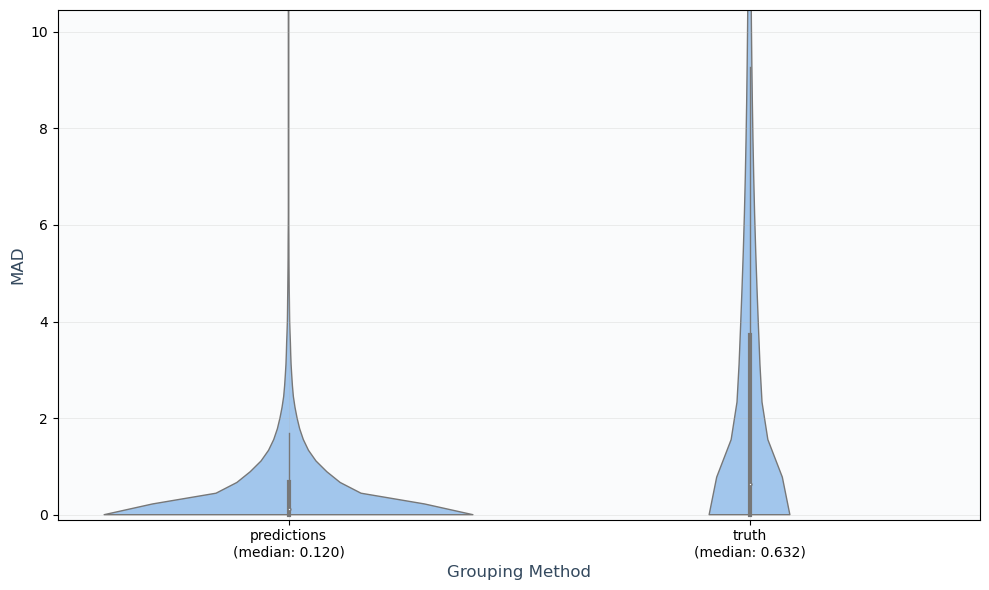

In [7]:
create_MAD_comparison_violinplot([mad_predictions,mad_truth],["predictions","truth"],title="",percentile_cutoff=0.95)

## Regular comparison

In [8]:
mad_predictions=df_pool.groupby('modified_sequence')['predictions'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
mad_truth=df_pool.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()

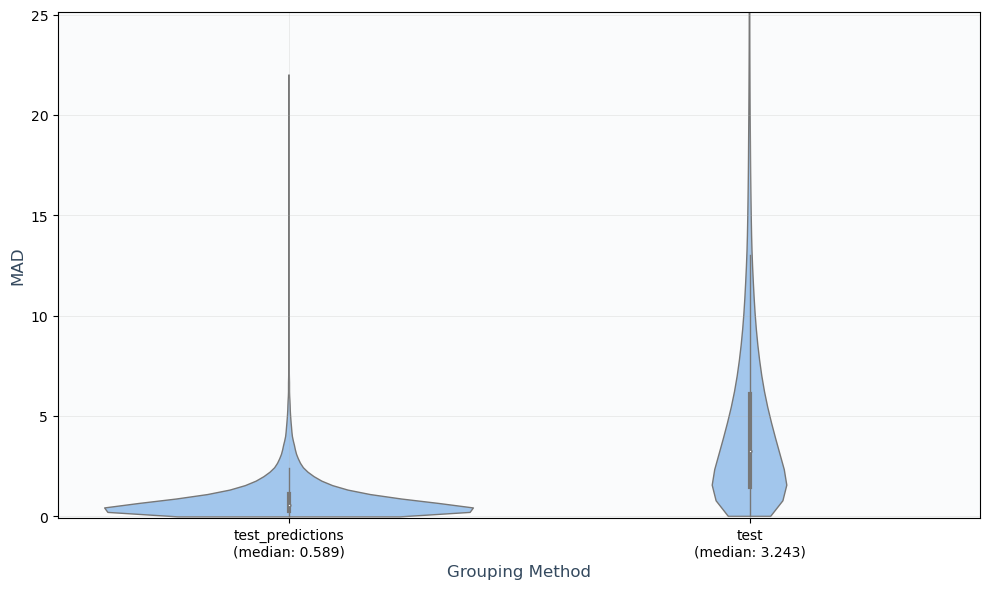

In [9]:
create_MAD_comparison_violinplot([mad_predictions,mad_truth],["test_predictions","test"],title="",percentile_cutoff=0.995)

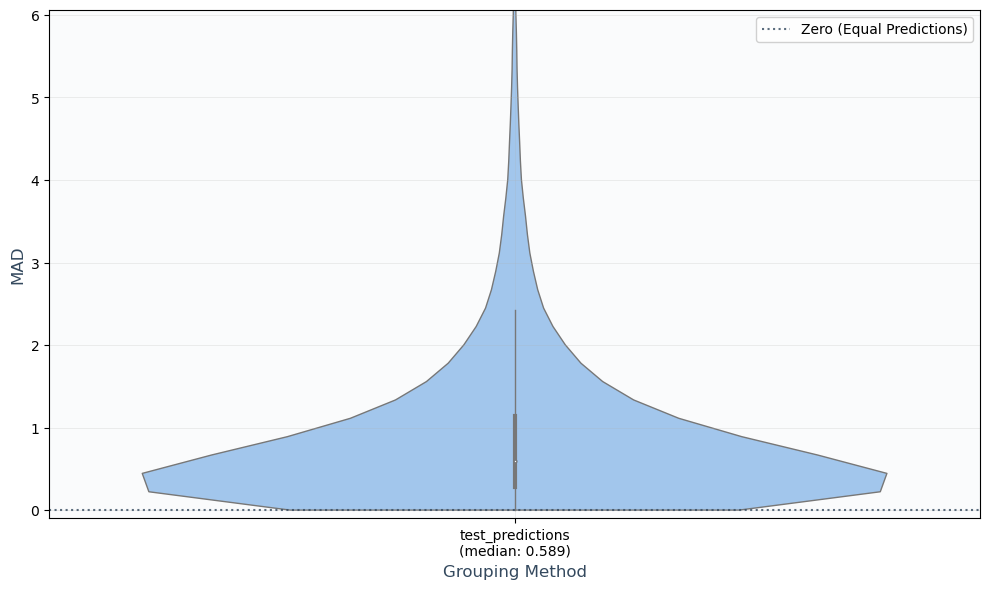

In [43]:
create_MAD_comparison_violinplot([mad_predictions],["test_predictions"],title="",percentile_cutoff=0.995)

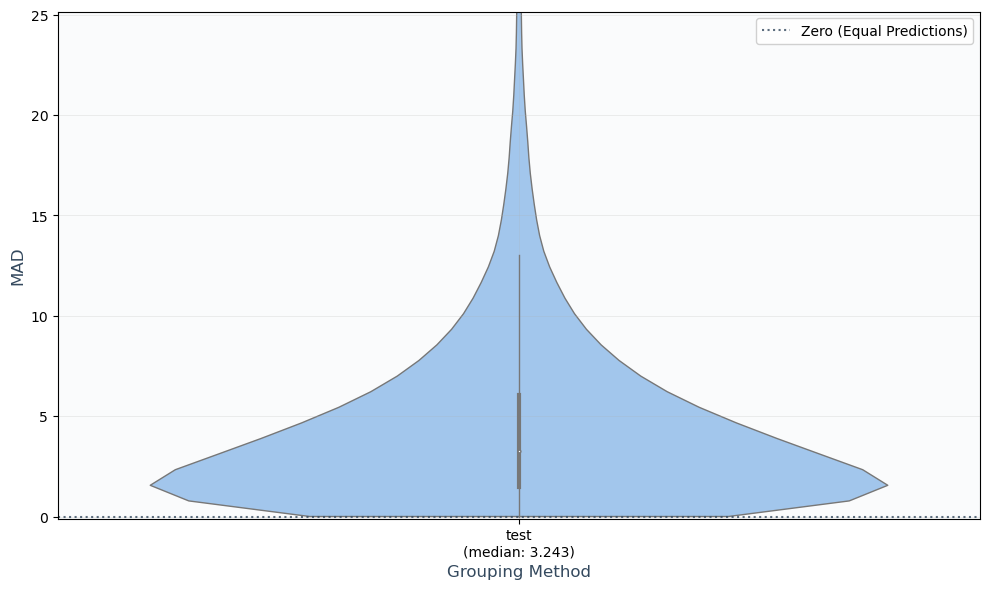

In [44]:
create_MAD_comparison_violinplot([mad_truth],["test"],title="",percentile_cutoff=0.995)

## Look for everything below 90th percentile

In [10]:
mad_truth = df_pool.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
threshold = np.percentile(mad_truth, 90)
indices_90 =  mad_truth[mad_truth<=threshold].index
df_90 = df_pool[df_pool['modified_sequence'].isin(indices_90)]

In [11]:
mad_truth_90=df_90.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
mad_prediction_90=df_90.groupby('modified_sequence')['predictions'].apply(lambda x: median_absolute_deviation(x,2)).dropna()

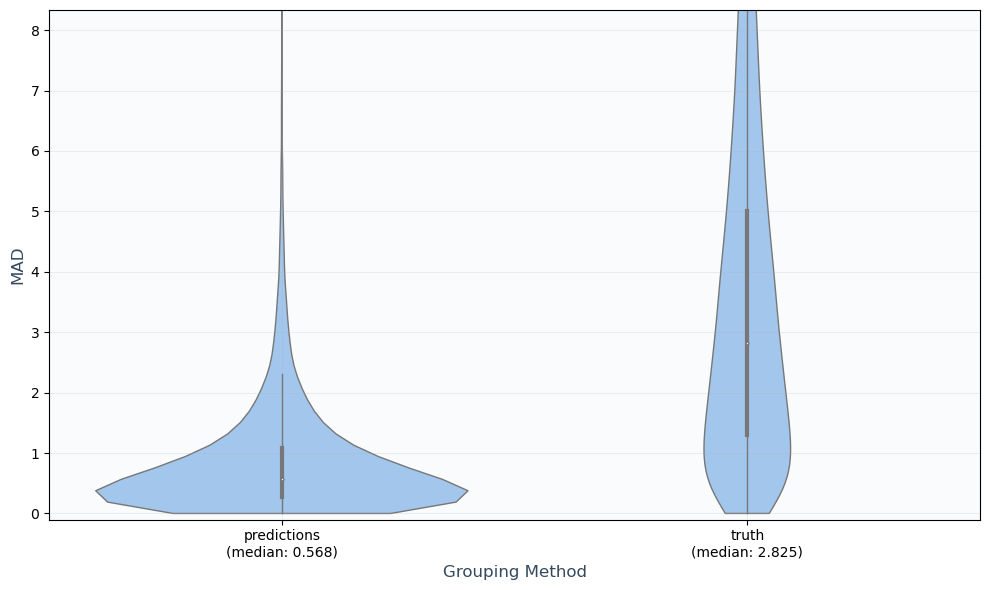

In [12]:
create_MAD_comparison_violinplot([mad_prediction_90,mad_truth_90],["predictions","truth"],percentile_cutoff=0.95)

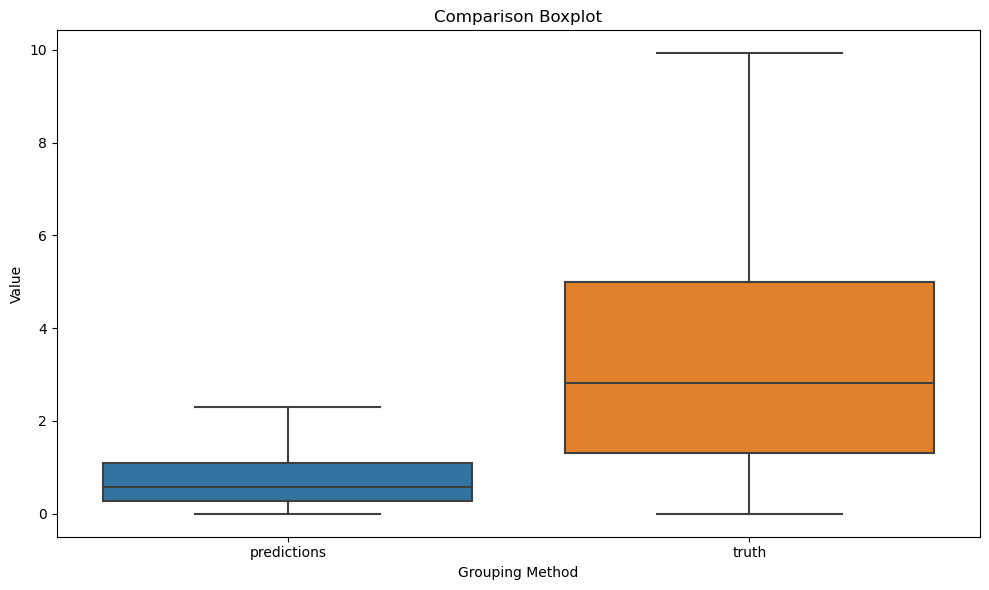

In [13]:
create_MAD_comparison_boxplot([mad_prediction_90,mad_truth_90],["predictions","truth"])

## Look for everything above 90th percentile

In [14]:
mad_truth = df_pool.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
threshold = np.percentile(mad_truth, 90)
indices_10 =  mad_truth[mad_truth>=threshold].index
df_10 = df_pool[df_pool['modified_sequence'].isin(indices_10)]

In [15]:
mad_truth_10=df_10.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
mad_prediction_10=df_10.groupby('modified_sequence')['predictions'].apply(lambda x: median_absolute_deviation(x,2)).dropna()

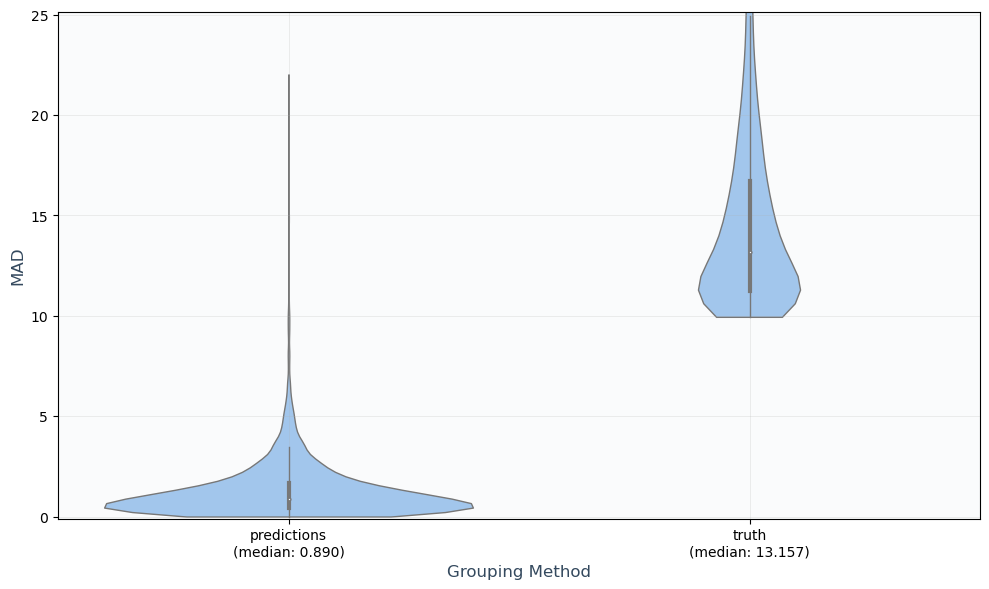

In [16]:
create_MAD_comparison_violinplot([mad_prediction_10,mad_truth_10],["predictions","truth"],percentile_cutoff=0.95)

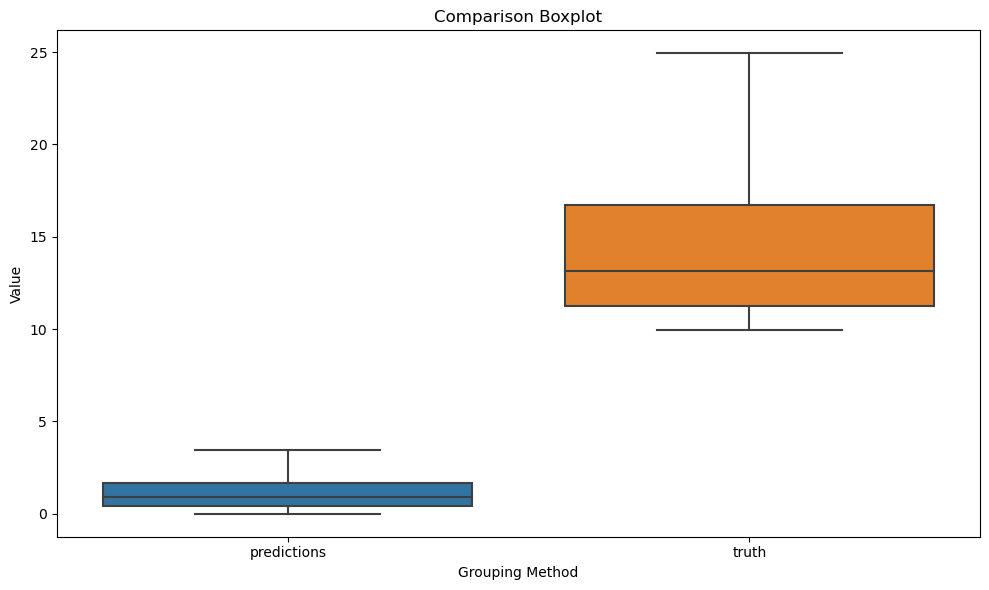

In [17]:
create_MAD_comparison_boxplot([mad_prediction_10,mad_truth_10],["predictions","truth"])

# checking how different the pool model does prediction compared to base model

In [18]:
difference = df_pool['predictions'] - df_base['predictions']

In [19]:
difference

17887501     0.288626
16662572    -1.226661
5891268     -0.673461
16367336    -5.195268
16782791     0.817774
              ...    
24665240    -3.054625
4462999     -4.461677
4274505      3.271095
1560787    -19.626569
11738345    -0.366796
Name: predictions, Length: 247344, dtype: float64

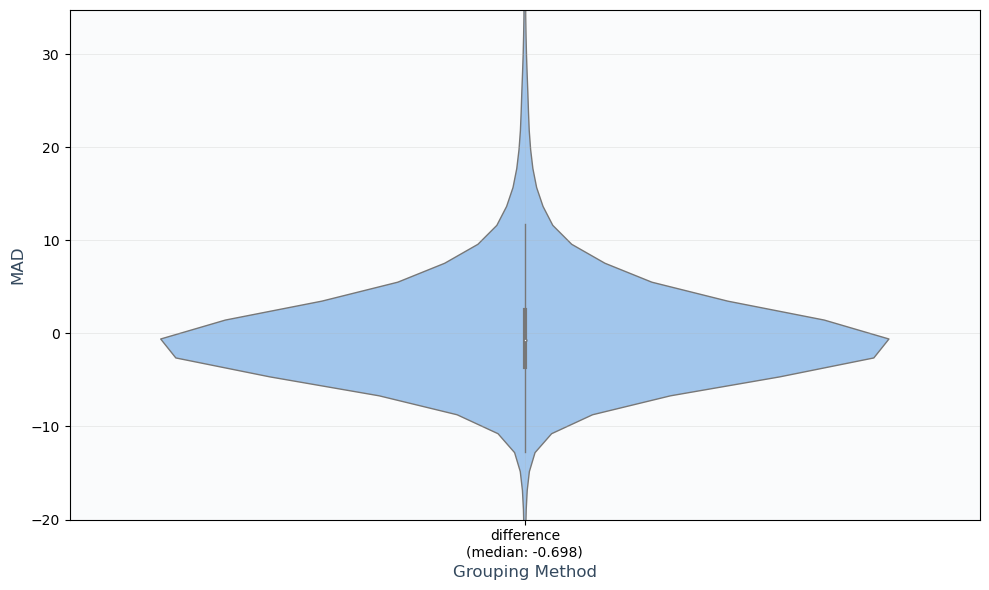

In [20]:
create_MAD_comparison_violinplot([difference],["difference"],lower=-20,percentile_cutoff=0.998)

# Checking if the model predicts in the right direction

In [21]:
difference_pool = df_pool['predictions'] - df_pool['label']

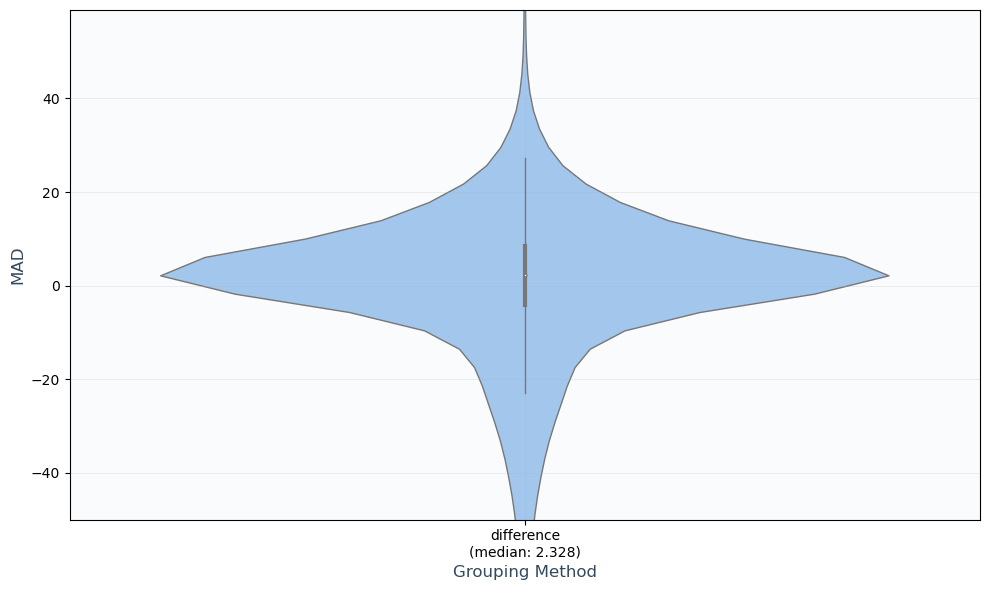

In [22]:
create_MAD_comparison_violinplot([difference_pool],["difference"],lower=-50,percentile_cutoff=0.998)

# Checking if the model predicts in the right direction

In [23]:
difference_pool = df_pool['label'] - df_pool['predictions']
difference_base =df_base['label'] - df_base['predictions']

In [24]:
improvement = difference_base-difference_pool

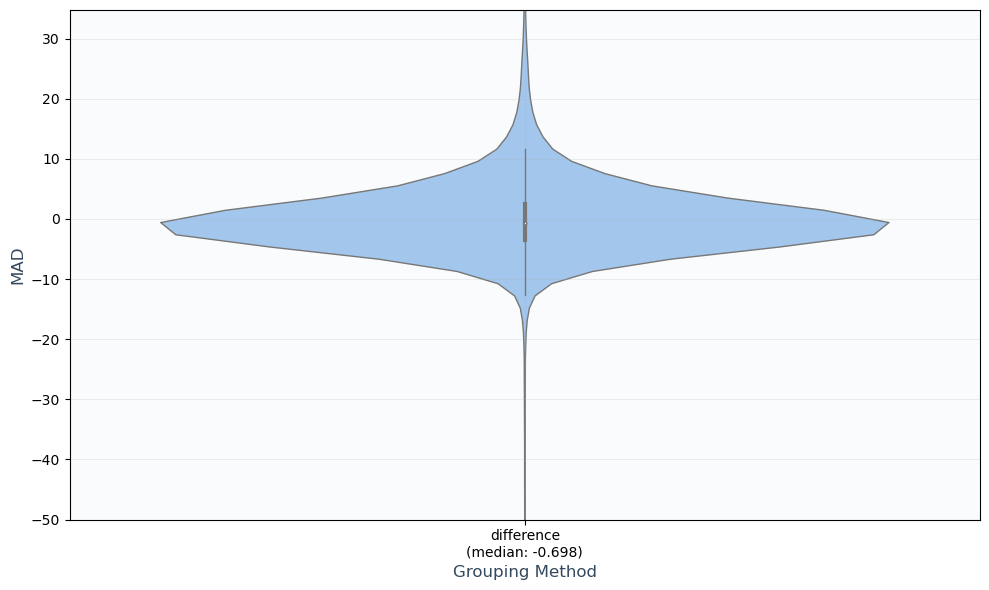

In [25]:
create_MAD_comparison_violinplot([improvement],["difference"],lower=-50,percentile_cutoff=0.998)

In [26]:
# Are the errors moving in the right direction?
base_signs = np.sign(difference_base)
your_signs = np.sign(difference_pool)

# Cases where your error has smaller magnitude AND same/opposite sign
better_cases = (np.abs(difference_pool) < np.abs(difference_base)) & (your_signs == base_signs)
worse_cases = (np.abs(difference_pool) > np.abs(difference_base))

# directional improvement

In [27]:
import os
import glob
import pandas as pd
def get_predictions(name):
    log_dir = "../final_results/seeds"
    dfs=[]
    for sub_dir in os.listdir(log_dir):
        if sub_dir.startswith(f"CONFIG={name}"):
            config_name = sub_dir.split(",")[0].replace("CONFIG=", "")
            version_path = os.path.join(log_dir, sub_dir, "version_0", "predictions")
            csv_file = glob.glob(os.path.join(version_path, f"test_loss=*.csv"))[0]
            print(csv_file)
            df = pd.read_csv(csv_file,index_col=0)
            dfs.append(df)
    return dfs

In [28]:
base_predictions = get_predictions("base")
pool_predictions = get_predictions("context")

../final_results/seeds\CONFIG=base_1,MODE=supervised,PRETRAIN=own,LR=0.0003262821190296,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTIVATION=gelu,SCHED=warmup_decay_cos,SIZE=180,NUMLAYERS=9,HIDDENSIZEMLP=120,DROPOUTMLP=0.1,ACTIVATIONMLP=relu,TYPE=base\version_0\predictions\test_loss=0.2451.csv
../final_results/seeds\CONFIG=base_117,MODE=supervised,PRETRAIN=own,LR=0.0003262821190296,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTIVATION=gelu,SCHED=warmup_decay_cos,SIZE=180,NUMLAYERS=9,HIDDENSIZEMLP=120,DROPOUTMLP=0.1,ACTIVATIONMLP=relu,TYPE=base\version_0\predictions\test_loss=0.2460.csv
../final_results/seeds\CONFIG=base_42,MODE=supervised,PRETRAIN=own,LR=0.0003262821190296,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTIVATION=gelu,SCHED=warmup_decay_cos,SIZE=180,NUMLAYERS=9,HIDDENSIZEMLP=120,DROPOUTMLP=0.1,ACTIVATIONMLP=relu,TYPE=base\version_0\predictions\test_loss=0.2450.csv
../final_results/seeds\CONFIG=context_1,MODE=supervised,PRETRAIN=own,LR=0.001,BS=2048,OPTIM=adamw,LOSS=mae,CLIP=True,ACTI

In [29]:
def directional_improvement(base_pred, your_pred, true_value):
    base_error = abs(base_pred - true_value)
    your_error = abs(your_pred - true_value)
    return (base_error - your_error)  # Positive = improvement

In [30]:
improvements=[]
for x in range(0,3):
    imp = directional_improvement(base_predictions[x]['predictions'],pool_predictions[x]['predictions'],base_predictions[x]['label'])
    improvements.append(imp)

In [31]:
def create_MAD_comparison_violinplot(data_series, labels,
                                     title='',
                                     xlabel='Grouping Method', ylabel='MAD',
                                     bw=0.2, percentile_cutoff=0.95,lower=-0.1):
    # Build the combined DataFrame
    df_list = []
    for data, label in zip(data_series, labels):
        df_list.append(pd.DataFrame({
            'MAD': data.values if hasattr(data, 'values') else data,
            'Group': label
        }))
    df_violin = pd.concat(df_list, ignore_index=True)

    # Calculate cutoff as 95th percentile of the group with highest values
    group_max_percentiles = []
    for group in df_violin['Group'].unique():
        group_data = df_violin[df_violin['Group'] == group]['MAD']
        group_95th = group_data.quantile(percentile_cutoff)
        group_max_percentiles.append(group_95th)

    cutoff = max(group_max_percentiles)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create vertical violin plot with a clean, light color
    sns.violinplot(x='Group', y='MAD', data=df_violin, cut=0, ax=ax,
                   inner='box', linewidth=1, bw=bw, color='#95C5F9', 
                   width=0.8)  # Light sky blue

    # Set y-axis limits (for MAD values)
    ax.set_ylim(lower, cutoff)

    # Add zero line to show baseline for equal predictions
    ax.axhline(y=0, color='#34495E', linestyle=':', alpha=0.8, linewidth=1.5, 
               label='Zero (Equal Predictions)')

    # Annotate the cutoff line with a softer red
    ax.axhline(y=cutoff, color='#FF6B6B', linestyle='--', alpha=0.8, linewidth=1.2)

    # Calculate medians and quantile ranges for x-axis labels
    unique_groups = df_violin['Group'].unique()
    x_labels_with_medians = []
    for group in unique_groups:
        group_data = df_violin[df_violin['Group'] == group]['MAD']
        group_median = group_data.median()
        x_labels_with_medians.append(f"{group}\n(median: {group_median:.3f})")

    # Set custom x-axis labels with medians
    ax.set_xticklabels(x_labels_with_medians)

    # Set plot titles and labels
    ax.set_title(title, fontsize=14, color='#2C3E50')
    ax.set_xlabel(xlabel, fontsize=12, color='#34495E')
    ax.set_ylabel(ylabel, fontsize=12, color='#34495E')

    # Clean up the plot appearance
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_facecolor('#FAFBFC')
    
    # Add legend to identify the zero line
    ax.legend(loc='upper right', framealpha=0.9)

    plt.tight_layout()
    plt.show()

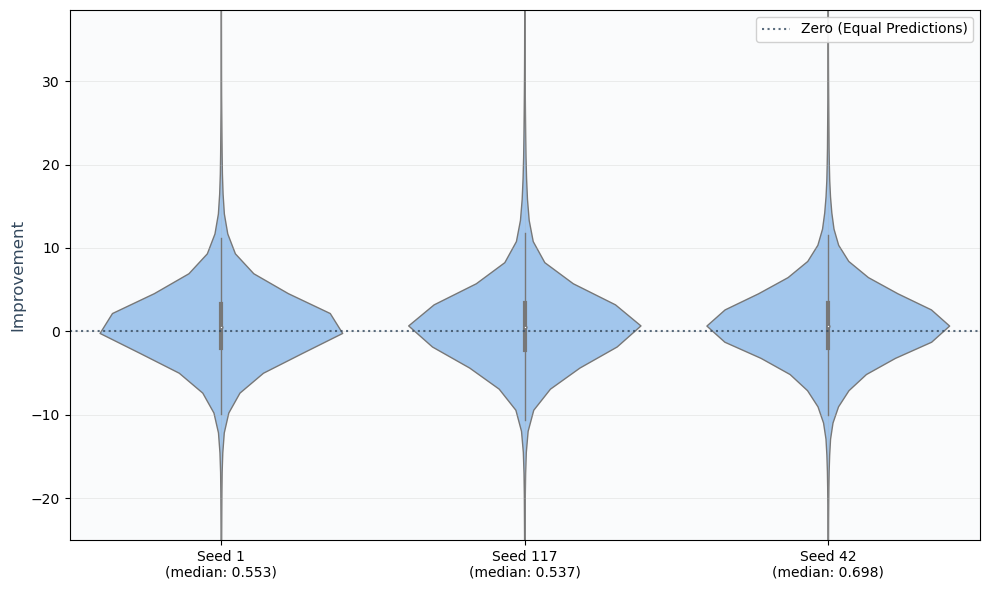

In [32]:
create_MAD_comparison_violinplot(improvements,["Seed 1","Seed 117","Seed 42"],ylabel="Improvement",xlabel="",lower=-25,percentile_cutoff=0.999)

# categorical

In [33]:
def directional_improvement_categorical(base_pred, your_pred, true_value):
    base_error = abs(base_pred - true_value)
    your_error = abs(your_pred - true_value)
    
    if your_error < base_error:
        return 1   # improvement
    elif your_error == base_error:
        return 0   # equal
    else:
        return -1  # worse

In [34]:
# Calculate all error differences first
all_diffs = []
for x in range(len(base_predictions)):
    base_error = abs(base_predictions[x]['predictions'] - base_predictions[x]['label'])
    pool_error = abs(pool_predictions[x]['predictions'] - base_predictions[x]['label'])
    all_diffs.append(pool_error - base_error)

all_diffs = np.array(all_diffs)

# Smart margin selection options:
margin = np.std(all_diffs) * 0.5  # Half a standard deviation
# or
margin = np.percentile(np.abs(all_diffs), 25)  # 25th percentile of absolute differences
# or
margin = np.median(np.abs(all_diffs[all_diffs != 0]))  # Median of non-zero differences

In [35]:
bimprovements = []
margin = 0.1

for x in range(0, 3):
    base_error = abs(base_predictions[x]['predictions'] - base_predictions[x]['label'])
    your_error = abs(pool_predictions[x]['predictions'] - base_predictions[x]['label'])

    diff = your_error - base_error
    imp_bin = np.where(diff < -margin, 1,           # your_error is significantly better
              np.where(abs(diff) <= margin, 0, -1)) # within margin is considered equal
    bimprovements.append(imp_bin)

In [36]:
bimprovements

[array([-1, -1,  1, ..., -1,  1, -1]),
 array([ 1,  1,  1, ..., -1, -1,  1]),
 array([-1, -1,  1, ..., -1, -1,  1])]

In [37]:
print(margin)

0.1


In [38]:
improvs=[]
equal=[]
worse=[]
for x in bimprovements:
    improvs.append((x == 1).sum())
    equal.append((x == 0).sum())
    worse.append((x == -1).sum())
    print("Improvement Results:")
    print(f"Improved: {(x == 1).sum()}")
    print(f"Equal: {(x == 0).sum()}")
    print(f"Worse: {(x == -1).sum()}")
    print(f"Total: {len(x)}")

Improvement Results:
Improved: 135640
Equal: 5719
Worse: 105985
Total: 247344
Improvement Results:
Improved: 134715
Equal: 5485
Worse: 107144
Total: 247344
Improvement Results:
Improved: 139200
Equal: 5713
Worse: 102431
Total: 247344


In [39]:
import statistics
print(statistics.mean(improvs))
print(statistics.mean(equal))
print(statistics.mean(worse))

136518
5639
105186


In [40]:
import statistics
print(statistics.stdev(improvs))
print(statistics.stdev(equal))
print(statistics.stdev(worse))

2367.9966216192115
133.40164916521834
2455.8285770794346


In [41]:
statistics.stdev([3.146,3.080,3.254])

0.08784076502399098

In [42]:
print("Improvement Results:")
print(f"Improved: {(imp_bin == 1).sum()}")
print(f"Equal: {(imp_bin == 0).sum()}")
print(f"Worse: {(imp_bin == -1).sum()}")
print(f"Total: {len(imp_bin)}")

Improvement Results:
Improved: 139200
Equal: 5713
Worse: 102431
Total: 247344
